In [4]:
# %matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [84]:
# Parameters
L = 100.0
Total_time = 100.0
g = 9.81
viscosity = 10**(-1)
N_x = 500 #real points aside from boundary
# N_t = 200
dx = L / (N_x + 2)
x = np.linspace(0, L, N_x + 2)

In [75]:
# #Boundary conditions
# h_left = lambda t: 0#Can make boundary a function of t
# h_right = lambda t: 0

u_left = lambda t: 0
u_left_prime = lambda t: 0
u_right = lambda t: 0
u_right_prime = lambda t: 0

# Initial conditions
h_initial = np.ones(N_x + 2, dtype=np.float64)
u_initial = np.zeros(N_x, dtype=np.float64)

# Add a perturbation as for the moment initial conditions are regular
h_initial[N_x//2 - 50:N_x//2 + 50] += 0.5

In [76]:
def central_difference(v, dx, i):
    return (v[i+1] - v[i-1])/(2*dx)

def second_order_central_difference(v, dx, i):
    return (v[i+1] - 2 * v[i] + v[i-1])/(dx**2)

def mod_foward_difference(v, dx, i):
    return (-3*v[i] + 4 * v[i+1] - v[i+2])/(2 * dx)

def mod_backward_difference(v, dx, i):
    return (3*v[i] - 4 * v[i-1] + v[i-2])/(2 * dx)

In [77]:
def pde_system_viscosity(t, y): #No boundary conditions for h
    h = y[:N_x + 2] # 0 Index used for point at boundary
    u = y[N_x + 2:]# 0 index used for first real point in grid after boundary

    dh_dx = np.zeros(N_x + 2, dtype=np.float64) #Also consider boundary for h
    du_dx = np.zeros(N_x, dtype=np.float64)
    dh_dt = np.zeros(N_x + 2, dtype=np.float64)
    du_dt = np.zeros(N_x, dtype=np.float64)

    for i in range(1, N_x - 1):
        dh_dx[i + 1] = central_difference(h, dx, i + 1)
        du_dx[i] = central_difference(u, dx, i)

    #Differential equations for points next to the boundary and boundary
    dh_dt[0] = - h[0] * u_left_prime(t) - u[0] * mod_foward_difference(h, dx, 0) #Left Boundary
    dh_dt[N_x + 1] = -h[N_x + 1] * u_right_prime(t)  - u_right(t) * mod_backward_difference(h, dx, N_x + 1) #Right Boundary

    du_dt[0] = -1/(2*dx) * (g*(h[2] - h[0]) + u[0]*(u[1] - u_left(t))) + viscosity * 1/(dx**2) * (u_left(t) - 2 * u[0] + u[1]) #First point after boundary
    dh_dt[1] = -1/(2*dx) * (h[0] * (u[1] - u_left(t))  - u[0] * (h[1] - h[0])) #First point in grid outside boundary

    dh_dt[N_x] = -1/(2*dx) * (h[N_x] * (u_right(t) - u[N_x - 2])  - u[N_x - 1] * (h[N_x + 1] - h[N_x - 1])) #Last point before boundary
    du_dt[N_x - 1] = -1/(2*dx) * (g*(h[N_x + 1] - h[N_x - 1]) + u[N_x - 1]*(u_right(t) - u[N_x - 2])) + (
        viscosity *  1/(dx**2) * (u_right(t) - 2 * u[N_x - 1] + u[N_x -2])
    ) #Last point before boundary

    #Differential equations for other points
    for i in range(1, N_x - 1):
        dh_dt[i + 1] = - h[i + 1] * du_dx[i + 1] - u[i + 1] * dh_dx[i + 1]
        du_dt[i] = - u[i] * du_dx[i] - g * dh_dx[i] + viscosity * second_order_central_difference(u, dx, i)
    
    return np.concatenate((dh_dt, du_dt))

In [57]:
def pde_system_modified(t, y): #No boundary conditions for h
    h = y[:N_x + 2] # 0 Index used for point at boundary
    u = y[N_x + 2:]# 0 index used for first real point in grid after boundary

    dh_dx = np.zeros(N_x + 2, dtype=np.float64) #Also consider boundary for h
    du_dx = np.zeros(N_x, dtype=np.float64)
    dh_dt = np.zeros(N_x + 2, dtype=np.float64)
    du_dt = np.zeros(N_x, dtype=np.float64)

    for i in range(1, N_x - 1):
        dh_dx[i + 1] = central_difference(h, dx, i + 1)
        du_dx[i] = central_difference(u, dx, i)

    #Differential equations for points next to the boundary and boundary
    dh_dt[0] = - h[0] * u_left_prime(t) - u[0] * mod_foward_difference(h, dx, 0) #Left Boundary
    dh_dt[N_x + 1] = -h[N_x + 1] * u_right_prime(t)  - u_right(t) * mod_backward_difference(h, dx, N_x + 1) #Right Boundary

    du_dt[0] = -1/(2*dx) * (g*(h[2] - h[0]) + u[0]*(u[1] - u_left(t))) #First point after boundary
    dh_dt[1] = -1/(2*dx) * (h[0] * (u[1] - u_left(t))  - u[0] * (h[1] - h[0])) #First point in grid outside boundary

    dh_dt[N_x] = -1/(2*dx) * (h[N_x] * (u_right(t) - u[N_x - 2])  - u[N_x - 1] * (h[N_x + 1] - h[N_x - 1])) #Last point before boundary
    du_dt[N_x - 1] = -1/(2*dx) * (g*(h[N_x + 1] - h[N_x - 1]) + u[N_x - 1]*(u_right(t) - u[N_x - 2])) #Last point before boundary

    #Differential equations for other points
    for i in range(1, N_x - 1):
        dh_dt[i + 1] = - h[i + 1] * du_dx[i + 1] - u[i + 1] * dh_dx[i + 1]
        du_dt[i] = - u[i] * du_dx[i] - g * dh_dx[i]
    
    return np.concatenate((dh_dt, du_dt))

In [36]:
# def pde_system(t, y):
#     # 0 index used for first real point in grid after boundary
#     # N_x-1 index used for last real point in grid before boundary
#     h = y[:N_x]
#     u = y[N_x:]

#     dh_dx = np.zeros(N_x, dtype=np.float64)
#     du_dx = np.zeros(N_x, dtype=np.float64)
#     dh_dt = np.zeros(N_x, dtype=np.float64)
#     du_dt = np.zeros(N_x, dtype=np.float64)

#     for i in range(1, N_x - 1):
#         dh_dx[i] = central_difference(h, dx, i)
#         du_dx[i] = central_difference(u, dx, i)

#     #Differential equations for points next to the boundary
#     dh_dt[0] = -1/(2*dx) * (h[0] * (u[1] - u_left(t))  - u[0] * (h[1] - h_left(t)))
#     du_dt[0] = -1/(2*dx) * (g*(h[1] - h_left(t)) + u[0]*(u[1] - u_left(t)))
#     dh_dt[N_x - 1] = -1/(2*dx) * (h[N_x - 1] * (u_right(t) - u[N_x - 2])  - u[N_x - 1] * (h_right(t) - h[N_x - 2]))
#     du_dt[N_x - 1] = -1/(2*dx) * (g*(h_right(t) - h[N_x - 2]) + u[N_x - 1]*(u_right(t) - u[N_x  -2]))    

#     #Differential equations for other points
#     for i in range(1, N_x - 1):
#         dh_dt[i] = - h[i] * du_dx[i] - u[i] * dh_dx[i]
#         du_dt[i] = - u[i] * du_dx[i] - g * dh_dx[i]
    
#     return np.concatenate((dh_dt, du_dt))

In [39]:
t0 = 0
tf = Total_time
y0 = np.concatenate((h_initial, u_initial))
sol1 = solve_ivp(pde_system_modified, t_span=(0,tf), y0=y0, method="RK45")

In [85]:
t0 = 0
tf = Total_time
sol1 = solve_ivp(pde_system_viscosity, t_span=(0,tf), y0=y0, method="RK45")

In [86]:
#Retrieve information from solution of IVP
# h_results_no_boundary = sol1.y[:N_x]
h_results = sol1.y[:N_x + 2]
u_results_no_boundary = sol1.y[N_x + 2:]
t_points = sol1.t
# Create a meshgrid for the 3D plot
T, X = np.meshgrid(t_points,x)

In [87]:
X1, T1 = np.meshgrid(x, t_points) #To consider correct orientation of axis

In [88]:
# h_left_boundary_evolution = np.array([[h_left(t) for t in t_points]]) #Evolution of boundary for results vector
# h_right_boundary_evolution = np.array([[h_right(t) for t in t_points]])
u_left_boundary_evolution = np.array([[u_left(t) for t in t_points]])
u_right_boundary_evolution = np.array([[u_right(t) for t in t_points]])

# h_results = np.concatenate((h_left_boundary_evolution, h_results_no_boundary, h_right_boundary_evolution)) #Add boundaries to results
u_results = np.concatenate((u_left_boundary_evolution, u_results_no_boundary, u_right_boundary_evolution))

h_results1 = h_results.transpose() #Used for orientation of axis
u_results1 = u_results.transpose()

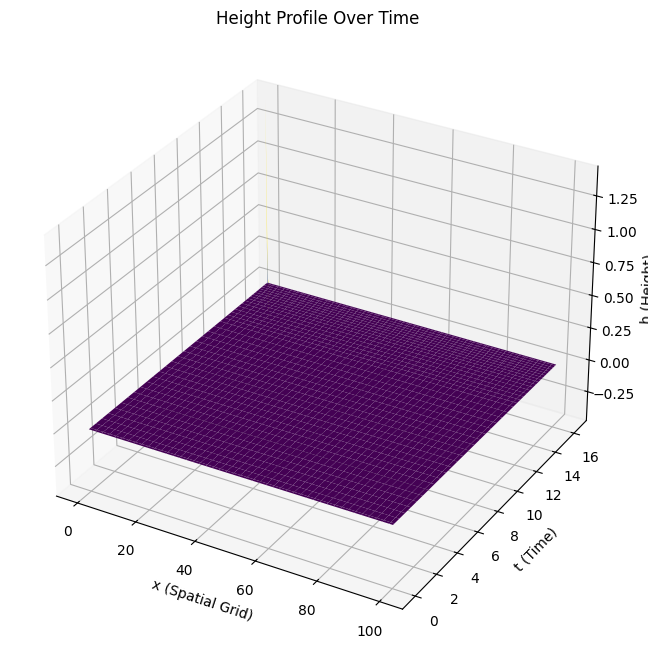

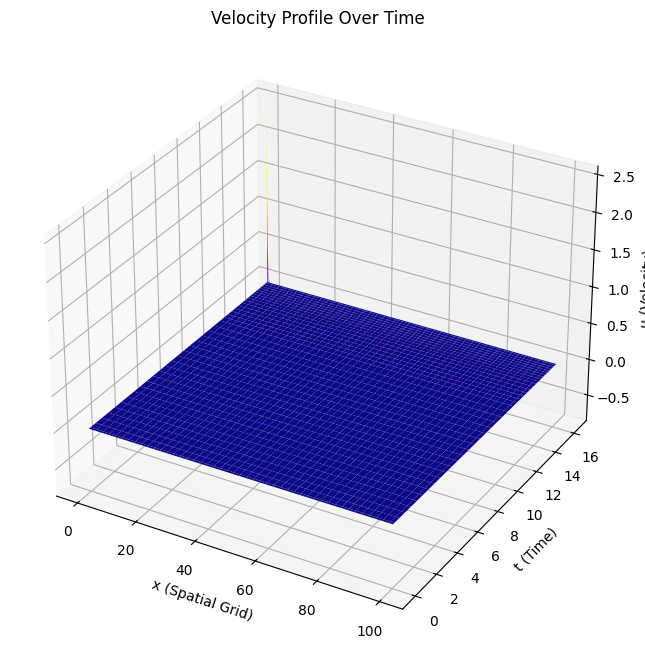

In [89]:
# Plot height (h) as a 3D surface
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1, T1, h_results1, cmap='viridis', edgecolor='none')
ax.set_xlabel('x (Spatial Grid)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('h (Height)')
ax.set_title('Height Profile Over Time')
plt.show()

# Plot velocity (u) as a 3D surface
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1, T1, u_results1, cmap='plasma', edgecolor='none')
ax.set_xlabel('x (Spatial Grid)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('u (Velocity)')
ax.set_title('Velocity Profile Over Time')
plt.show()

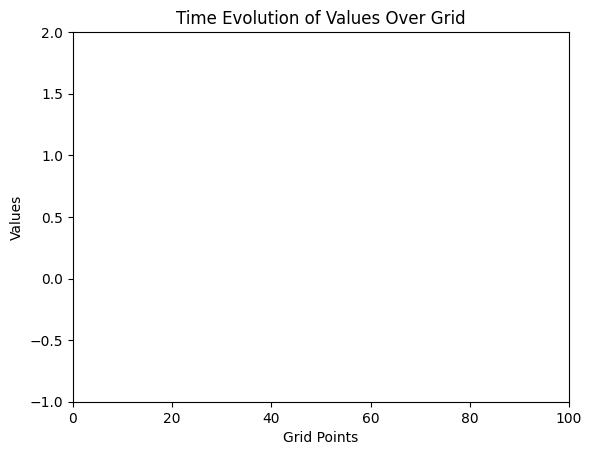

MovieWriter ffmpeg unavailable; using Pillow instead.


In [90]:
# Create the figure and axis
time_steps = len(h_results1)
values = h_results1
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Set up the plot limits
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-1, 2)
ax.set_xlabel("Grid Points")
ax.set_ylabel("Values")
ax.set_title("Time Evolution of Values Over Grid")

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Animation function to update the plot
def update(frame):
    y = values[frame, :]  # Values at the current time step
    line.set_data(x, y)   # Update the line with grid points and corresponding values
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=time_steps, init_func=init, blit=True, interval=100)

# Display the animation
plt.show()
ani.save('animation.gif', writer='ffmpeg', fps=30)